# Necessary packages and functions

In [1]:
# %matplotlib qt #pop-up windows for figures
# %matplotlib widget #in-line visualization of figures
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
import scipy as sp
from scipy.stats import multivariate_normal
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D 
import random
import sys
from scipy import linalg
from scipy.signal import savgol_filter
from matplotlib.pyplot import savefig

sigmoid = lambda x,c,a: 1/(1 + np.exp(-a*(x-c))) #reward sensitivities

# MP Linear Chain (Figure 3)

Parameters

In [2]:
num_states=4 #number of states in the MP
alpha=0.01 #learning rate
num_gammas=100 #number of gammas

# the gammas are equally separated in the 1/log(gamma) space:
taus=np.linspace(0.01,3,num_gammas)
range_g=np.exp(-1/taus)
# range_g=np.linspace(0.0,1,num_gammas)

# range_g=np.linspace(0,1,num_gammas)

num_trials=3000 #number of trials
width=13 #width of the reward sensitivities
num_h=250 #number of h's
range_h=np.linspace(-3,3,num_h) #theta_h range

In [3]:
i_g=0 #counter for the gammas
V_gamma=np.zeros((len(range_g),num_states,num_h)) #initialize gamma-space

for gamma in range_g[0:-1]: #loop over gammas
    i_g=i_g+1
    V=np.zeros((num_states,num_h))
    for t in range(1,num_trials): #loop over trials
        for s in range(1,num_states+1): #walk along the chain
            
            if s==1:
                state=1
                r1=np.random.choice([-2,2]);
            elif s==2:
                state=2
                r2=np.random.choice([-2,2])
            elif s==3:
                state=3
                r3=np.random.choice([-1,1])
            elif s==4:
                state=4
                r4=np.random.choice([-1,1])
            
            
            if state==1:
                    R=sigmoid(r1,range_h,width); #R=f_h(r1)
                    delta= R + gamma*V[1,:] - V[0,:]
                    V[0,:]=V[0,:]+alpha*delta;
            elif state==2:
                    R=sigmoid(r2,range_h,width); 
                    delta= R + gamma*V[2,:] - V[1,:];
                    V[1,:]=V[1,:]+alpha*delta;   
            elif state==3:
                    R=sigmoid(r3,range_h,width);
                    delta= R + gamma*V[3,:] - V[2,:];
                    V[2,:]=V[2,:]+alpha*delta;  
            elif state==4:
                    R=sigmoid(r4,range_h,width);
                    delta= R - V[3,:];
                    V[3,:]=V[3,:]+alpha*delta;
    V_gamma[i_g,:,:]=V
    print(i_g,end=' ')


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

### $\gamma$-Space

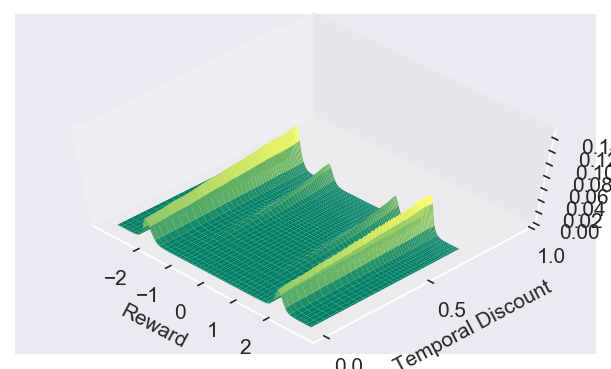

In [9]:
V_gamma2=V_gamma[4:-1,0,:]
Z=V_gamma2[:,0:-2]-V_gamma2[:,1:-1]

X,Y=np.meshgrid(range_h[0:-2],range_g[4:-1]);

for h in range(0,num_h-2):
    Z[:,h]=savgol_filter(Z[:,h], 15, 1)  

    
fig = plt.figure(figsize=[5,3],dpi=150)
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='summer'
                       , edgecolor='none',alpha=1)
ax.view_init(60, -45)
ax.set_zlim(0,0.15)
ax.grid(b=None)
plt.yticks([0,0.5,1])
plt.xticks([-2,-1,0,1,2])
ax.set_zlabel('Convergence value')
ax.set_ylabel('Temporal Discount')
ax.set_xlabel('Reward')
plt.show()

### $\tau$-space by approximating $\mathcal{L}^{-1}$ with SVD

In [8]:
alpha_reg=0.2 #Regularization parameter

K=4 #Temporal horizon
delta_t=1 #Temporal resolution

#define matrix F:
F=np.zeros((len(range_g),K))
for i_g in range(0,len(range_g)):
    for i_t in range(0,K):
        F[i_g,i_t]=range_g[i_g]**(i_t*delta_t)

        
U, lam, V = linalg.svd(F) #SVD decomposition of F

#set up gamma-space:
V_gamma2=V_gamma[:,0,:]
Z=V_gamma2[:,0:-2]-V_gamma2[:,1:-1]


#smooth gamma-space (it might not be necessary, it helps if the input is *very* noisy):
# for h in range(0,num_h-2):
#     Z[:,h]=savgol_filter(Z[:,h], 5, 1)

#Linearly recover tau-space from eigenspace of F:
tau_space=np.zeros((K,num_h-2))
for h in range(0,num_h-2):
    term=np.zeros((1,K))
    for i in range(0,len(lam)):
        fi=lam[i]**2/(alpha_reg**2+lam[i]**2)
        new=fi*(((U[:,i]@Z[:,h])*V[i,:] )/lam[i])
        term=term+new
    tau_space[:,h]=term

    
#smooth gamma-space (it might not be necessary, use for a smoother visualization):
# for h in range(0,num_h-2):
#     tau_space[:,h]=savgol_filter(tau_space[:,h], 11, 1)


#Normalization (it is not really necessary for this very short temporal horizon T=4):
tau_space[tau_space<0]=0 #make all probabilities positive
for i in range(0,len(tau_space)): #normalize
    if np.nansum(tau_space[i,:])>0.0:
        tau_space[i,:]=tau_space[i,:]/np.nansum(tau_space[i,:])
        


#Thin black lines that indicate true (smoothed) reward probability in tau-space of Fig.3:
i_t=0
P_r=np.nan*np.zeros((len(taus)-1,num_h+1))
for tau in taus[0:-2]:
    i_t=i_t+1
    for n in range(1,num_h):
        if tau<1.6:
            R=0.5*(sigmoid(-2,range_h[n],width)+sigmoid(2,range_h[n],width));
        elif tau>1.6:
            R=0.5*(sigmoid(-1,range_h[n],width)+sigmoid(1,range_h[n],width));
        P_r[i_t,n]=R
P_r=P_r[:,0:-1]-P_r[:,1:]



#Plot figure
plt.close(); fig=plt.figure()
plt.clf()
ax = fig.gca(projection='3d')
X,Y=np.meshgrid(range_h[0:-2],delta_t*np.linspace(0,K-1,K)) #grid to plot

surf = ax.plot_surface(X, Y, tau_space, cmap='summer'
                           , edgecolor='none',alpha=1)

[X1,Y1]=np.meshgrid(range_h[0:-1],taus[3:5]-0.12);
Z1=P_r[3:5,0:-1];
surf = ax.plot_surface(X1, Y1, Z1, color=[0,0,0]
                           , edgecolor='none',alpha=0.4)

[X1,Y1]=np.meshgrid(range_h[0:-1],taus[27:29]+0.18);
Z1=P_r[27:29,0:-1]*0.95;
surf = ax.plot_surface(X1, Y1, Z1, color=[0,0,0]
                           , edgecolor='none',alpha=0.4)

[X1,Y1]=np.meshgrid(range_h[0:-1],taus[57:59]+0.25);
Z1=P_r[57:59,0:-1]*1;
surf = ax.plot_surface(X1, Y1, Z1, color=[0,0,0]
                           , edgecolor='none',alpha=0.4)

[X1,Y1]=np.meshgrid(range_h[0:-1],taus[57:59]+1.25);
Z1=P_r[57:59,0:-1]*1;
surf = ax.plot_surface(X1, Y1, Z1, color=[0,0,0]
                           , edgecolor='none',alpha=0.4)


ax.grid(b=None)

ax.view_init(60, -45)
plt.yticks([0,1,2,3])
plt.xticks([-2,-1,0,1,2])
ax.set_zlim(0,0.085)
ax.set_zlabel('Probability')
ax.set_ylabel('Future Time')
ax.set_xlabel('Reward')
fig.canvas.draw_idle()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:80: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: Z contains NaN values. This may result in rendering artifacts.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: UserWarning: Z contains NaN values. This may result in rendering artifacts.


# MDP Double Chain (Figure 5)

Parameters

In [452]:
num_states=6
alpha=0.01
num_gammas=100

# range_g=np.linspace(0,1,num_gammas)
taus=np.linspace(0.01,num_states,num_gammas)
range_g=np.exp(-1/taus)

num_trials=3000
width=25
num_h=150
range_h=np.linspace(-0.25,1.25,num_h)

In [453]:
i_g=0
V_gamma=np.zeros((len(range_g),2*num_states-1,num_h))
for gamma in range_g[0:-2]:
    i_g=i_g+1
   #set V such that components [0:num_states-1] belong to branch 1 (top in Figure), 
   #and components [num_states:2*num_states-1] to branch 2 (bottom)
    V=np.zeros((2*num_states-1,num_h))
    for t in range(1,num_trials):
        for s in range(1,num_states+1):

            
            if s==1:
                r=0;
                branch=1+np.random.binomial(1, 0.5)
            elif s==2 and branch==1:
                r=0.6
            elif s==2 and branch==2:
                r=0
            elif s==3:
                r=0
            elif s==4:
                r=0
            elif s==5:
                r=0
            elif s==6 and branch==1:
                r=0
            elif s==6 and branch==2:
                r=1 
                
            
            R=sigmoid(r,range_h,width)
            if s==1 and branch==1:
                delta= R + gamma*V[s,:] - V[s-1,:]
                V[s-1,:]=V[s-1,:]+alpha*delta
            elif s==1 and branch==2:
                delta= R + gamma*V[s+num_states,:] - V[s-1,:]
                V[s-1,:]=V[s-1,:]+alpha*delta
                
            elif s<num_states and branch==1:
                delta= R + gamma*V[s,:] - V[s-1,:]
                V[s-1,:]=V[s-1,:]+alpha*delta
            elif s==num_states and branch==1:
                delta= R  - V[s-1,:]
                V[s-1,:]=V[s-1,:]+alpha*delta
                
            elif s<num_states and branch==2:
                delta= R + gamma*V[s+num_states-1,:] - V[s+num_states-2,:]
                V[s+num_states-2,:]=V[s+num_states-2,:]+alpha*delta
            elif s==num_states and branch==2:
                delta= R  - V[s+num_states-2,:]
                V[s+num_states-2,:]=V[s+num_states-2,:]+alpha*delta

    V_gamma[i_g,:,:]=V
    print(i_g,end=' ')


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 

### Gamma space

In [493]:
fig = plt.figure()
ax = fig.gca(projection='3d')
V_gamma2=V_gamma[:,0,:]
Z=V_gamma2[:,0:-2]-V_gamma2[:,1:-1]

X,Y=np.meshgrid(range_h[0:-2],range_g);

# for h in range(0,num_h-2):
#     Z[:,h]=savgol_filter(Z[:,h], 11, 1)  

surf = ax.plot_surface(X, Y, Z, cmap='summer'
                       , edgecolor='none',vmin=0,vmax=0.07)

ax.view_init(50, -45)
ax.set_zlabel('Convergence value')
ax.set_ylabel('Temporal Discount')
ax.set_xlabel('Reward')

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### $\mathcal{L}^{-1}$ with SVD

In [459]:

alpha_reg=0.55 #regularization parameter


K=num_states-1 #Temporal horizon of tau-space
delta_t=1/4 #Temporal resolution (change alpha_reg accordingly)
K=int(K/delta_t) #K is now the length of the tau_space

#Set up matrix F
F=np.zeros((len(range_g),K))
for i_g in range(0,len(range_g)):
    for i_t in range(0,K):
        F[i_g,i_t]=range_g[i_g]**(i_t*delta_t)
     

    
U, lam, V = linalg.svd(F)


#set up gamma-space:
V_gamma2=V_gamma[:,0,:]
Z=V_gamma2[:,0:-2]-V_gamma2[:,1:-1]

#smooth gamma space (not necessary):
# for h in range(0,num_h-2):
#     Z[:,h]=savgol_filter(Z[:,h], 7, 1)

#Linearly recover tau-space from eigenspace of F:
tau_space=np.zeros((K,num_h-2))
for h in range(0,num_h-2):
    term=np.zeros((1,K))
    for i in range(0,len(lam)):
        fi=lam[i]**2/(alpha_reg**2+lam[i]**2)
        new=fi*(((U[:,i]@Z[:,h])*V[i,:] )/lam[i])
        term=term+new
    tau_space[:,h]=term

#Smooth tau-space (not necessary):
# for h in range(0,num_h-2):
#     tau_space[:,h]=savgol_filter(tau_space[:,h], 7, 1)


#Normalization
tau_space[tau_space<0]=0 #Probabilities are positive
for i in range(0,len(tau_space)): #normalize
    if np.nansum(tau_space[i,:])>0.001:
        tau_space[i,:]=tau_space[i,:]/np.nansum(tau_space[i,:])
        


plt.close(); fig=plt.figure()

plt.clf()
ax = fig.gca(projection='3d')

X,Y=np.meshgrid(range_h[0:-2],delta_t*np.linspace(0,K,K))

surf = ax.plot_surface(X, Y, tau_space, cmap='summer'
                           , edgecolor='none')


ax.view_init(50, -45)
# plt.ylim(0, 3.1)
ax.set_zlim(0,0.035)
fig.canvas.draw_idle()
ax.set_zlabel('Probability')
ax.set_ylabel('Future Time')
ax.set_xlabel('Reward')
# savefig('demo.png', transparent=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Laplace code that only varies along $\gamma$, not $h$ (Figure A.1)

Parameters

In [494]:

num_states=9
length_branch_1=1
length_branch_2=8
alpha=0.1
num_gammas=100
range_g=np.linspace(0,1,num_gammas)
# taus=np.linspace(0.1,num_states,num_gammas)
# range_g=np.exp(-1/taus)

num_trials=3000


In [495]:
i_g=0
V_gamma=np.zeros((len(range_g),num_states))
for gamma in range_g[0:-1]:
    i_g=i_g+1
    V=np.zeros((num_states))
    for t in range(1,num_trials):
        for s in range(1,num_states+1):
            
            r=0
            state=s-1
            if state==0:
                branch=1+np.random.binomial(1, 1)
            elif state==length_branch_1 and branch==2: 
                r=1
            elif state==length_branch_2 and branch==2: 
                r=1
    

            end_state=num_states-1
                
            if state<end_state:
                delta= r + gamma*V[state+1] - V[state]
                V[state]=V[state]+alpha*delta;
            elif state==end_state:
                delta= r  - V[state]
                V[state]=V[state]+alpha*delta;
                
                
    V_gamma[i_g,:]=V[:] 
    print(i_g,end=' ')


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [500]:
plt.close(); fig=plt.figure()
Z=V_gamma[:,0]

plt.plot(range_g[:],Z*1.04,color='tab:blue',linewidth=4)
plt.plot(range_g[:],Z*1.04,'o',color='tab:blue',markersize=6)
plt.yticks(ticks=[0,1,2])
plt.xlabel('Temporal Discount ($\gamma$)')
plt.ylabel('Convergence Value ($V_\gamma$)')
plt.grid()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### $\mathcal{L}^{-1}$ with SVD

In [504]:

alpha_reg=0 # tau-space Without regularization
# alpha_reg=0.0001 # tau-space With regularization



Z=V_gamma[1:-1,0]

K=num_states+2
delta_t=1

A=np.zeros((len(range_g[1:-1]),K))
for i_g in range(0,len(range_g[1:-1])):
    for i_t in range(0,K):
        A[i_g,i_t]=range_g[i_g]**(i_t*delta_t)
     

    
U, lam, V = linalg.svd(A)

tau_space=np.zeros((K,1))

term=np.zeros((1,K))
for i in range(0,len(lam)):
    fi=lam[i]**2/((alpha_reg)**2+lam[i]**2)
    new=fi*(((U[:,i]@Z)*V[i,:] )/lam[i])
    term=term+new
tau_space=term


plt.close(); fig=plt.figure()

plt.plot(delta_t*np.linspace(0,K-1,K),tau_space.T,linewidth=4,color='tab:blue')
plt.plot(delta_t*np.linspace(0,K-1,K),tau_space.T,'o',color='tab:blue',markersize=6)
plt.yticks(ticks=[0,1])
plt.xlabel('Future Time ($\\tau$)')
plt.ylabel('Expected reward $E[r_\\tau]$')
plt.grid()


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Coffee example from the video presentation

Parameters

In [460]:
num_states=15 #number of states in the MP
alpha=0.01 #learning rate
num_gammas=100 #number of gammas

# the gammas are equally separated in the 1/log(gamma) space:
taus=np.linspace(0.01,num_states,num_gammas)
range_g=np.exp(-1/taus)
# range_g=np.linspace(0.0,1,num_gammas)

# range_g=np.linspace(0,1,num_gammas)

num_trials=5000 #number of trials
width=2 #width of the reward sensitivities
num_h=250 #number of h's
range_h=np.linspace(-6,8,num_h) #theta_h range

In [461]:
i_g=0 #counter for the gammas
V_gamma=np.zeros((len(range_g),num_states,num_h)) #initialize gamma-space

for gamma in range_g[0:-1]: #loop over gammas
    i_g=i_g+1
    V=np.zeros((num_states,num_h))
    for t in range(1,num_trials): #loop over trials
        for s in range(1,num_states+1): #walk along the chain
            
            if s==1:
                r=np.random.choice([-5,-4])
            elif s==2:
                r=np.random.choice([-4,-3])
            elif s==3:
                r=np.random.choice([-3,-2])
            elif s==4:
                r=np.random.choice([-2,-1])
            elif s==5:
                r=np.random.choice([4,5,6])
            elif s==6:
                r=np.random.choice([4,5,6])
            elif s==7:
                r=np.random.choice([4,5,6])
            elif s==8:
                r=np.random.choice([4,5,6])
            elif s==9:
                r=np.random.choice([4,5,6])
            elif s==10:
                r=np.random.choice([4,5,6])
            elif s==11:
                r=np.random.choice([4,5])
            elif s==12:
                r=np.random.choice([3,4])
            elif s==13:
                r=np.random.choice([2,3])
            elif s==14:
                r=np.random.choice([1,2])
            elif s==15:
                r=np.random.choice([0,1])
            
            if s<num_states:
                R=sigmoid(r,range_h,width);
                delta= R + gamma*V[s,:] - V[s-1,:]
                V[s-1,:]=V[s-1,:]+alpha*delta
            else:
                delta= R - V[s-1,:]
                V[s-1,:]=V[s-1,:]+alpha*delta
                
    V_gamma[i_g,:,:]=V
    print(i_g,end=' ')


1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

### $\gamma$-Space

In [462]:
from scipy import linalg
from scipy.signal import savgol_filter
fig = plt.figure()
ax = fig.gca(projection='3d')
V_gamma2=V_gamma[4:-1,0,:]
Z=V_gamma2[:,0:-2]-V_gamma2[:,1:-1]

X,Y=np.meshgrid(range_h[0:-2],range_g[4:-1]);


surf = ax.plot_surface(X, Y, Z, cmap='summer'
                       , edgecolor='none',alpha=1)

ax.view_init(60, -45)

ax.set_zlim(0,0.15)

ax.grid(b=None)
plt.yticks([0,0.5,1])
plt.xticks([-2,-1,0,1,2])

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### $\tau$-space by approximating $\mathcal{L}^{-1}$ with SVD

In [492]:
alpha_reg=0.3 #Regularization parameter

K=14 #Temporal horizon
delta_t=1/2 #Temporal resolution
K=int(K/delta_t)

#define matrix F:
F=np.zeros((len(range_g),K))
for i_g in range(0,len(range_g)):
    for i_t in range(0,K):
        F[i_g,i_t]=range_g[i_g]**(i_t*delta_t)

        
U, lam, V = linalg.svd(F) #SVD decomposition of F

#set up gamma-space:
V_gamma2=V_gamma[:,0,:]
Z=V_gamma2[:,0:-2]-V_gamma2[:,1:-1]


#Linearly recover tau-space from eigenspace of F:
tau_space=np.zeros((K,num_h-2))
for h in range(0,num_h-2):
    term=np.zeros((1,K))
    for i in range(0,len(lam)):
        fi=lam[i]**2/(alpha_reg**2+lam[i]**2)
        new=fi*(((U[:,i]@Z[:,h])*V[i,:] )/lam[i])
        term=term+new
    tau_space[:,h]=term



#Normalization:
tau_space[tau_space<0]=0 #make all probabilities positive
for i in range(0,len(tau_space)): #normalize
    if np.nansum(tau_space[i,:])>0.0:
        tau_space[i,:]=tau_space[i,:]/np.nansum(tau_space[i,:])
        


#smooth gamma-space (it might not be necessary, use for a smoother visualization):
for h in range(0,num_h-2):
    tau_space[:,h]=savgol_filter(tau_space[:,h], 7, 1)


#Plot figure
plt.close(); fig=plt.figure()
plt.clf()
ax = fig.gca(projection='3d')

X,Y=np.meshgrid(range_h[0:-2],delta_t*np.linspace(0,K,K)) #grid to plot

surf = ax.plot_surface(X, Y, tau_space, cmap='summer'
                           , edgecolor='none',alpha=1)
# ax.grid(b=None)
ax.grid(b=None)
ax.view_init(70, -45)
# plt.yticks(np.linspace(0,num_states,num_states+1))
ax.set_zlabel('Probability')
ax.set_ylabel('Future Time')
ax.set_xlabel('Reward')
# ax.set_zlim(0,0.085)
fig.canvas.draw_idle()
# savefig('demo.png', transparent=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …